# Creating Spectral Data Cubes from a Parametric Galaxy

In this example we show how to create a spectral data cube from a parametric galaxy. For this we'll generate a disk and a bulge morphology and make spectral data cubes for each individual component before combining them. Feel free to skip over the setup to get to the spectral data cube synthesis as the process is well documented elsewhere (e.g. the composite galaxy [docs](../parametric/generate_composite_galaxy.ipynb)).

## The setup

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from synthesizer.grid import Grid
from synthesizer.imaging import SpectralCube
from synthesizer.parametric import SFH, Stars, ZDist
from synthesizer.parametric.galaxy import Galaxy
from synthesizer.parametric.morphology import Sersic2D
from unyt import Myr, degree, kpc

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

# Set the seed
np.random.seed(42)

As always we first need a `Grid` object from which to extract spectra.

In [2]:
# Define the grid
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=np.logspace(2, 5, 600))

We now need to create our parametric model for the disk and bulge stellar distributions and create `Galaxy` objects using those models.

In [3]:
gal_start = time.time()

# Define the SFH and metallicity distribution
metal_dist = ZDist.Normal(mean=0.015, sigma=0.005)
sfh = SFH.Constant(duration=200 * Myr)

# Define the morphology using a simple effective radius and slope
morph = Sersic2D(
    r_eff=1 * kpc,
    sersic_index=1.0,
    ellipticity=0,
    theta=0 * degree,
)

# Create the Stars object
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    morphology=morph,
    initial_mass=10**9.0,
)

# Initialise a parametric Galaxy for the bulge
bulge = Galaxy(stars, redshift=3)

# Define the SFH and metallicity distribution
metal_dist = ZDist.Normal(mean=0.01, sigma=0.005)
sfh = SFH.Constant(duration=100 * Myr)

# Define the morphology using a simple effective radius and slope
morph = Sersic2D(
    r_eff=5 * kpc,
    sersic_index=1.0,
    ellipticity=0.4,
    theta=1 * degree,
)

# Create the Stars object
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    morphology=morph,
    initial_mass=10**9.5,
)

# Initialise a parametric Galaxy for the disk
disk = Galaxy(stars, redshift=3)

print("Galaxies created, took:", time.time() - gal_start)

Galaxies created, took: 0.013281822204589844


With our galaxy morphologies made we can get the spectra for each.

In [4]:
spectra_start = time.time()

# Generate stellar spectra
bulge_sed = bulge.stars.get_spectra_reprocessed(grid)
disk_sed = disk.stars.get_spectra_reprocessed(grid)

print("Spectra created, took:", time.time() - spectra_start)

Spectra created, took: 0.006132364273071289


## Spectral Data Cube Creation

We now have most of the ingredients we need to generate a spectral data cube from our galaxy. The missing ingredients are the wavelength array of our spectral data cube and its resolution and FOV. We'll define these below and move on to making the spectral data cube.

In [5]:
# Define the width of the image
width = 30 * kpc

# Define image resolution (here we arbitrarily set it to 100 pixels
# along an axis)
resolution = width / 200

# Define the wavelength array
lam = np.linspace(10**3, 10**4.5, 1000)

print(
    "Data cube spatial width is %.2f kpc with a %.2f kpc spaxel resolution"
    % (width.value, resolution.value)
)

Data cube spatial width is 30.00 kpc with a 0.15 kpc spaxel resolution


Finally we can create each individual spectral cube and then add them together to get the final galaxy spectral data cube. To make the spectral cubes we have to pass the `Sed` objects we made, the quantity we want to populate the spectral cube with, and the density grid defined by each morphology. The possible quantities are `"lnu"`, `"luminosity"` or `"llam"` for rest frame luminosities, or `"fnu"`, `"flam"` or `"flux"` for fluxes (the latter 3 require `get_fnu` or `get_fnu0` to have been called). We will make a cube populated with `"flux"`.

In [6]:
cube_start = time.time()

# Get the data cubes
bulge_cube = SpectralCube(resolution=resolution, lam=lam, fov=width)
disk_cube = SpectralCube(resolution=resolution, lam=lam, fov=width)

# And get the cube itself
bulge_cube.get_data_cube_smoothed(
    bulge_sed,
    quantity="lnu",
    density_grid=bulge.stars.morphology.get_density_grid(
        bulge_cube.resolution, bulge_cube.npix
    ),
)
disk_cube.get_data_cube_smoothed(
    disk_sed,
    quantity="lnu",
    density_grid=disk.stars.morphology.get_density_grid(
        disk_cube.resolution, disk_cube.npix
    ),
)

# Combine each individual component
cube = bulge_cube + disk_cube

print("Spectral data cube created, took:", time.time() - cube_start)

Spectral data cube created, took: 0.2514314651489258


Now we have our parametric spectral data cube. We can see what we've made by making an animation.

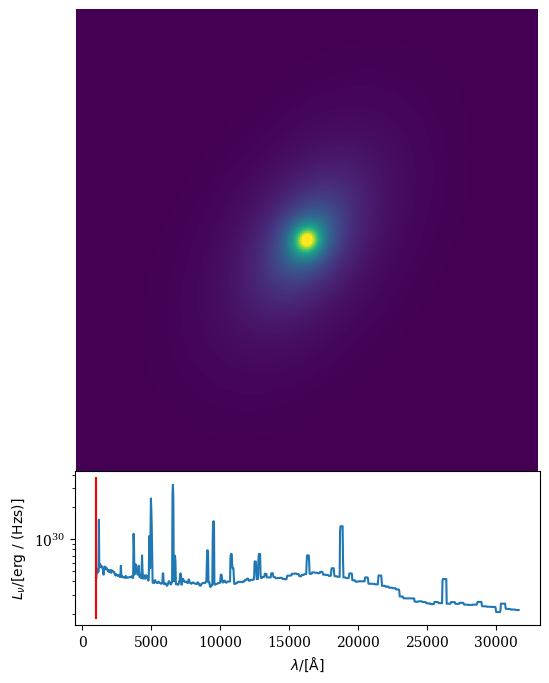

In [7]:
# Animate the data cube
ani = cube.animate_data_cube(fps=240, show=True)

### Galaxy helper method

If you don't want to use the low level `SpectralCube` object we also include a helper method on a galaxy.

In [8]:
bulge_cube = bulge.get_data_cube(
    resolution, width, lam, stellar_spectra="intrinsic", quantity="luminosity"
)
disk_cube = disk.get_data_cube(
    resolution, width, lam, stellar_spectra="intrinsic", quantity="luminosity"
)
cube = bulge_cube + disk_cube